In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
regr = LinearRegression()
import xgboost
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

Importing raw data

In [2]:
df =pd.read_csv("../../../data/kc_house_data.csv")

Checking for null values

In [3]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

removing id and sqft_basement columns

In [4]:
df = df.drop("id", axis=1)
df = df.drop("sqft_basement", axis=1)

Created a new column by combining bathrooms and bedrooms

In [5]:
bath_and_bed = df['bedrooms'] + df['bathrooms']
df["bath_and_bed"] = bath_and_bed

removed null values in view column

In [6]:
df['view'] = df['view'].fillna(0)

Feature engineered and new column that turns year renovated into a true or false column with 0 and 1

In [7]:
df['renovation_yes'] = (~np.isnan(df['yr_renovated'])).astype(int)

checking correlation

In [8]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath_and_bed,renovation_yes
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.393497,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.467376,0.002127
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078354,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,0.894855,0.012265
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186016,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.843155,0.013109
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.281715,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.755961,0.009294
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075054,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.066362,0.009493
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028414,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.373192,0.006914
waterfront,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.405107,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002,0.033475,0.001438
view,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.405107,1.000000,0.045622,0.249082,0.166017,-0.054452,0.100977,0.085059,0.006321,-0.077702,0.278928,0.073083,0.145960,-0.004769
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045622,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,-0.049224,0.002522
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.087383,0.249082,-0.146896,1.000000,0.756073,0.447865,0.016669,-0.185771,0.113575,0.200341,0.713867,0.120981,0.570173,0.006782


created a model looking at four featues

In [9]:
f = 'price ~ sqft_living + grade + bathrooms + bedrooms'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     6429.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:20:43   Log-Likelihood:            -2.9892e+05
No. Observations:               21597   AIC:                         5.979e+05
Df Residuals:                   21592   BIC:                         5.979e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.813e+05    1.5e+04    -32.145      0.000   -5.11e+05   -4.52e+05
sqft_living   226.9304      3.592     63.177      0.000     219.890     233.971
grade        9.674e+04   2323.206     41.640      0.000    9.22e+04    1.01e+05
bathrooms   -2.722e+04   3491.838     -7.794      0.000   -3.41e+04   -2.04e+04
bedrooms    -3.965e+04   2304.000    -17.210      0.000   -4.42e+04   -3.51e+04
==============================================================================
Omnibus:                    16463.655   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           894495.760
Skew:                           3.179   Prob(JB):                         0.00
Kurtosis:                      33.880   Cond. No.                     2.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

trying to improve r-squared by adding more features

In [10]:
f = 'price ~ sqft_living + grade + bathrooms + bedrooms + sqft_above + lat'
model = ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     5534.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:20:43   Log-Likelihood:            -2.9733e+05
No. Observations:               21597   AIC:                         5.947e+05
Df Residuals:                   21590   BIC:                         5.947e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.071e+07   5.47e+05    -56.109      0.000   -3.18e+07   -2.96e+07
sqft_living   260.3274      4.282     60.796      0.000     251.934     268.720
grade        8.971e+04   2261.289     39.671      0.000    8.53e+04    9.41e+04
bathrooms   -1.841e+04   3248.263     -5.668      0.000   -2.48e+04    -1.2e+04
bedrooms    -3.768e+04   2142.652    -17.584      0.000   -4.19e+04   -3.35e+04
sqft_above    -48.4462      4.144    -11.690      0.000     -56.569     -40.323
lat          6.366e+05   1.15e+04     55.156      0.000    6.14e+05    6.59e+05
==============================================================================
Omnibus:                    18783.513   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1487650.576
Skew:                           3.797   Prob(JB):                         0.00
Kurtosis:                      42.944   Cond. No.                     1.04e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Created a new column

In [11]:
df["divide"]=df["sqft_living"] / df["sqft_living"]

Created Baseline model

In [12]:
X = df[["sqft_living", "sqft_living15", "bath_and_bed", ]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)

<ipython-input-12-149172e5c2a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


In [13]:
model = LinearRegression()
model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print('RMSE: ', (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.5837187643419486
Test r2: 0.5560497239988504
RMSE:  229825.47901894944


Created a new model

In [14]:
X = df[["sqft_living", "sqft_living15", "bathrooms", "yr_built", "lat", "condition", "sqft_above", "view", "bedrooms"]]
X["grade_sq"] = df["grade"]**4

y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, random_state=42)


model.fit(X_train2, y_train2)

predict_train = model.predict(X_train2)
predict_test = model.predict(X_test2)

print('Training r2:', (r2_score(y_train2, predict_train)))
print('Test r2:', (r2_score(y_test2, predict_test)))
print('RMSE: ', (np.sqrt(mean_squared_error(y_test2, predict_test))))

Training r2: 0.7077155343316595
Test r2: 0.6958341627671161
RMSE:  190233.1616484885


<ipython-input-14-7fc057ab0a9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["grade_sq"] = df["grade"]**4


In [15]:

poly = PolynomialFeatures(include_bias=False)

poly_train = poly.fit_transform(X_train2)
poly_test = poly.fit_transform(X_test2)

polymodel = LinearRegression()

polymodel.fit(poly_train, y_train2)

polypredict = polymodel.predict(poly_test)
print(r2_score(y_test2, polypredict))
print('RMSE: ', (np.sqrt(mean_squared_error(y_test2, polypredict))))



0.7430586377566792
RMSE:  174842.90754968557


In [16]:
df['high_grade'] = df['grade'] > 6

In [17]:
df.corr()['grade']['high_grade']

0.5270340561374787

In [18]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath_and_bed,renovation_yes,divide,high_grade
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,...,0.0,98178,47.5112,-122.257,1340,5650,4.00,1,1.0,True
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,1991.0,98125,47.7210,-122.319,1690,7639,5.25,1,1.0,True
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,NaN,98028,47.7379,-122.233,2720,8062,3.00,0,1.0,False
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,0.0,98136,47.5208,-122.393,1360,5000,7.00,1,1.0,True
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,98074,47.6168,-122.045,1800,7503,5.00,1,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,...,0.0,98103,47.6993,-122.346,1530,1509,5.50,1,1.0,True
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,...,0.0,98146,47.5107,-122.362,1830,7200,6.50,1,1.0,True
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,...,0.0,98144,47.5944,-122.299,1020,2007,2.75,1,1.0,True
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3,...,0.0,98027,47.5345,-122.069,1410,1287,5.50,1,1.0,True


In [19]:
zip_df = df[['price', 'zipcode']]
zip_df.head()

,price,zipcode
0,221900.0,98178
1,538000.0,98125
2,180000.0,98028
3,604000.0,98136
4,510000.0,98074


In [20]:
zip_df.groupby('zipcode').mean().sort_values('price', ascending=False).head(10)

,price
zipcode,
98039,2.161300e+06
98004,1.356524e+06
98040,1.194874e+06
98112,1.096239e+06
98102,8.996077e+05
98109,8.800778e+05
98105,8.632289e+05
98006,8.599386e+05
98119,8.497148e+05


In [24]:
from scipy import stats

In [30]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath_and_bed,renovation_yes,divide
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.0
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233181,3.409825,7.657915,...,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.489026,0.822105,1.0
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.764673,0.650546,1.173200,...,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,1.477276,0.382433,0.0
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.500000,0.000000,1.0
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.500000,1.000000,1.0
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,5.500000,1.000000,1.0
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.500000,1.000000,1.0
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,34.750000,1.000000,1.0


In [26]:
df_temp = df[(np.abs(stats.zscore(df["price"])) < 3)]

In [29]:
df_temp.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath_and_bed,renovation_yes,divide
count,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,18857.000000,21191.000000,21191.000000,21191.000000,...,21191.000000,17425.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.0
mean,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,0.004242,0.204757,3.408051,7.605304,...,1970.926525,79.373142,98078.289651,47.558989,-122.213732,1960.388656,12631.720589,5.443608,0.822283,1.0
std,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,0.064998,0.706625,0.648903,1.108906,...,29.285262,390.038728,53.407481,0.139455,0.141433,655.151335,27193.757002,1.436658,0.382283,0.0
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.500000,0.000000,1.0
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1951.000000,0.000000,98033.000000,47.467050,-122.329000,1480.000000,5080.000000,4.500000,1.000000,1.0
50%,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1975.000000,0.000000,98065.000000,47.569900,-122.231000,1820.000000,7576.000000,5.500000,1.000000,1.0
75%,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,1996.000000,0.000000,98118.000000,47.678800,-122.124000,2330.000000,10000.000000,6.500000,1.000000,1.0
max,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,34.750000,1.000000,1.0


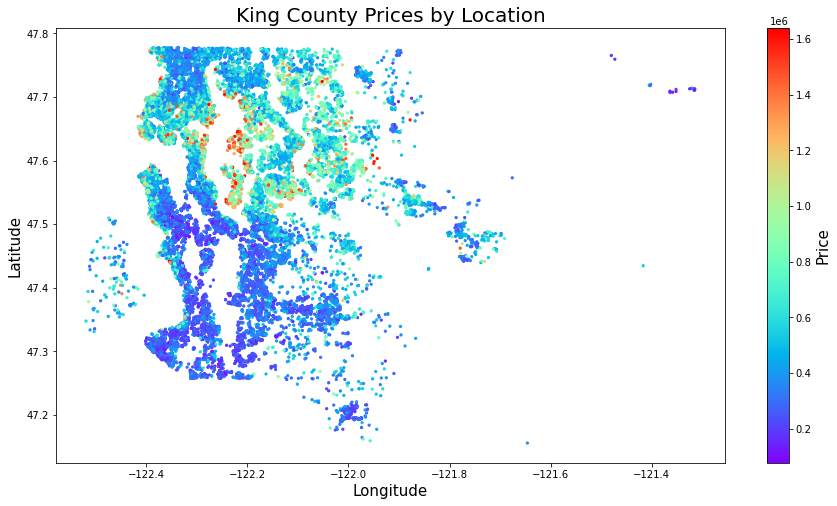

In [52]:
plt.figure(figsize = (15,8))
plt.scatter(df_temp.long, df_temp.lat ,c=df_temp.price,  cmap = 'rainbow', s=5)
plt.colorbar().set_label('Price', fontsize=15)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('King County Prices by Location', fontsize=20)
plt.show()



In [56]:
df.date = pd.to_datetime(df.date)

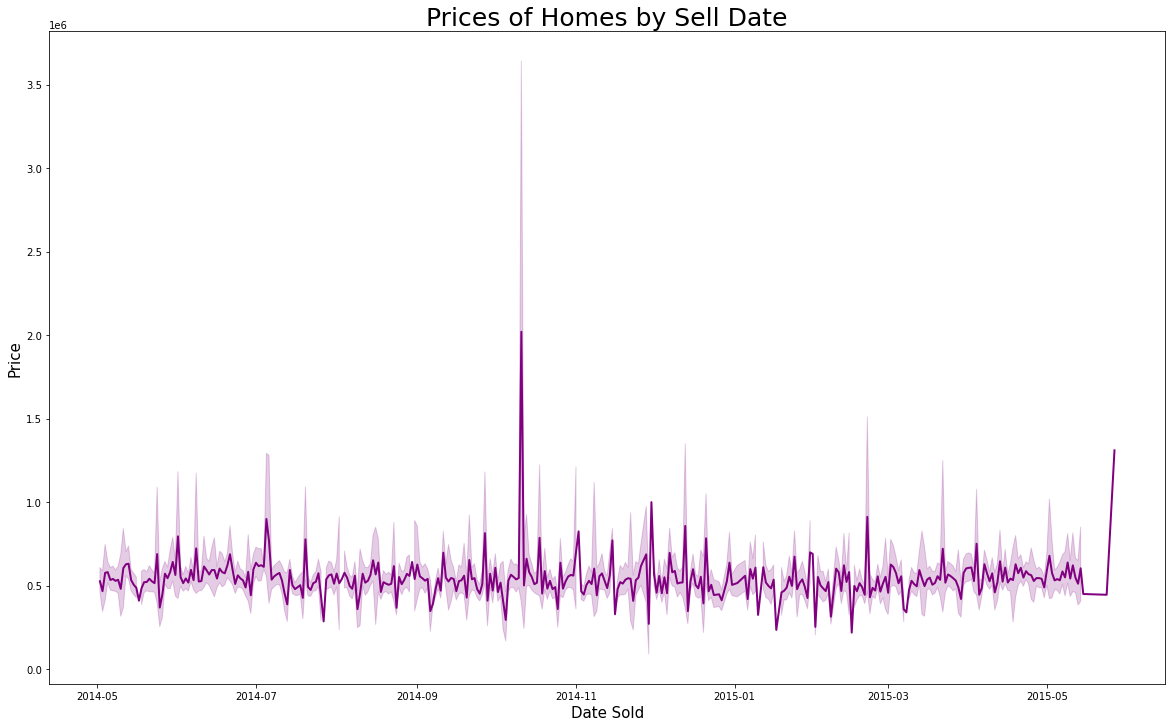

In [57]:
plt.figure(figsize = (20,12))
sns.lineplot(x="date",y="price", data = df, linewidth=2, color='purple');

plt.title('Prices of Homes by Sell Date', fontsize = 25)
plt.xlabel('Date Sold', fontsize = 15)
plt.ylabel('Price', fontsize = 15);

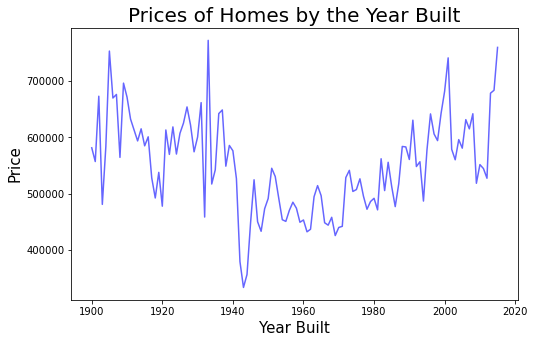

In [58]:
plt.figure(figsize = (8,5))
sns.lineplot(x="yr_built",y="price", data = df, color='blue', err_style=None, alpha=0.6);

plt.title('Prices of Homes by the Year Built', fontsize = 20)
plt.xlabel('Year Built', fontsize = 15)
plt.ylabel('Price', fontsize = 15);
